In [132]:
import numpy as np
import random
import matplotlib.pyplot as plt


In [133]:
maze_str = """
........G
.........
.........
########.
.........
...S.....
"""

maze_str_2 = """
........G
.........
.........
.########
.........
...S.....
"""

In [134]:
def maze_array(maze):
    return np.array([list(line.strip()) for line in maze.splitlines() if line.strip()])

class Maze:
    def __init__(self, maze_str):
        self.maze = maze_array(maze_str)
        self.start = tuple(np.argwhere(self.maze == 'S').tolist()[0])
        self.goal = tuple(np.argwhere(self.maze == 'G').tolist()[0])

        self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # right, down, left, up

    def valid_actions(self, state):
        return self.actions
    
    def is_valid_action(self, state, action):
        new_state = (state[0] + action[0], state[1] + action[1])
        return self.is_valid_state(new_state)
    
    def non_terminal_states(self):
        states = np.argwhere(~np.isin(self.maze, ['#', 'G'])).tolist()
        states = [tuple(state) for state in states]
        return states
    
    def all_states(self):
        states = np.argwhere(self.maze != '#').tolist()
        states = [tuple(state) for state in states]
        return states
    
    def all_possible_states(self):
        return [(i, j) for i in range(self.maze.shape[0]) for j in range(self.maze.shape[1])]
    
    def is_valid_state(self, state):
        return (0 <= state[0] < self.maze.shape[0] and
                0 <= state[1] < self.maze.shape[1] and
                self.maze[state] != '#')

    
    def step(self, state, action):
        new_state = (state[0] + action[0], state[1] + action[1])
        
        if not self.is_valid_state(new_state):
            new_state = state

        is_terminal = np.array_equal(new_state, self.goal)

        if is_terminal:
            reward = 1
        else:
            reward = 0
        
        return new_state, reward, is_terminal

    def __str__(self):
        return '\n'.join(''.join(row) for row in self.maze)

In [149]:
def block_maze(maze):
    maze.maze[3, 0] = '.'
    maze.maze[3, maze.maze.shape[1] - 1] = '#'

    return maze

def shortcut_maze(maze):
    maze.maze[3, maze.maze.shape[1] - 1] = '.'

    return maze 

In [150]:
class Policy:
    def __init__(self, maze, epsilon=0.1):
        self.maze = maze
        self.epsilon = epsilon

        self.Q = {
            state: {action: 0 for action in maze.valid_actions(state)}
            for state in maze.all_possible_states()
        }

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return random.choice(list(self.Q[state].keys()))
        else:
            max_value = max(self.Q[state].values())
            best_actions = [
                action for action, value in self.Q[state].items() if value == max_value
            ]
            return random.choice(best_actions)

    def get_action_plus(
        self, state, current_time_step, state_action_last_visit, exploration_bonus
    ):
        if np.random.rand() < self.epsilon:
            return random.choice(list(self.Q[state].keys()))
        else:
            action_values = {
                action: value
                + exploration_bonus
                * np.sqrt(current_time_step - state_action_last_visit[state][action])
                for action, value in self.Q[state].items()
            }
            max_value = max(action_values.values())
            
            best_actions = [
                action for action, value in action_values.items() if value == max_value
            ]
            
            return random.choice(best_actions)

    def update(self, state, action, new_value):
        self.Q[state][action] = new_value

    def q_learning_update(self, state, action, reward, next_state, alpha, gamma):
        td_error = (
            reward + gamma * max(self.Q[next_state].values()) - self.Q[state][action]
        )
        self.Q[state][action] += alpha * td_error

In [152]:
def dyna_q(
    maze,
    policy=None,
    time_steps=6000,
    alpha=0.1,
    gamma=0.9,
    n_planning_steps=10,
    update_time=None,
    update_function=None,
):
    if policy is None:
        policy = Policy(maze)

    # Dictionary to keep track of actions taken in each state
    taken_actions = {}
    cumulative_rewards = [0]

    state = maze.start

    for step in range(time_steps):
        # print(f"Step {step + 1}/{time_steps}, Current State: {state}, Cumulative Reward: {cumulative_rewards[-1]}")
        if update_function is not None and step == update_time:
            maze = update_function(maze)

        action = policy.get_action(state)

        if state not in taken_actions:
            taken_actions[state] = set([action])
        else:
            taken_actions[state].add(action)

        next_state, reward, done = maze.step(state, action)

        cumulative_rewards.append(cumulative_rewards[-1] + reward)

        policy.q_learning_update(state, action, reward, next_state, alpha, gamma)

        # Planning step
        for _ in range(n_planning_steps):
            planning_state = random.choice(list(taken_actions.keys()))
            planning_action = random.choice(list(taken_actions[planning_state]))
            planning_next_state, planning_reward, _ = maze.step(
                planning_state, planning_action
            )

            policy.q_learning_update(
                planning_state,
                planning_action,
                planning_reward,
                planning_next_state,
                alpha,
                gamma,
            )

        state = next_state

        if done:
            # print(f"Reached goal at step {step + 1}")
            state = maze.start

    return policy, cumulative_rewards[1:]

In [153]:
def dyna_q_plus(
    maze,
    policy=None,
    time_steps=6000,
    alpha=0.1,
    gamma=0.9,
    n_planning_steps=10,
    exploration_bonus=0.1,
    update_time=None,
    update_function=None,
):
    if policy is None:
        policy = Policy(maze)

    # Dictionary to keep track of actions taken in each state
    state_action_last_visit = {
        state: {action: 0 for action in maze.valid_actions(state)}
        for state in maze.all_possible_states()
    }

    cumulative_rewards = [0]

    state = maze.start

    for step in range(1, time_steps+1):
        # print(f"Step {step + 1}/{time_steps}, Current State: {state}, Cumulative Reward: {cumulative_rewards[-1]}")
        if update_function is not None and step == update_time:
            maze = update_function(maze)

        action = policy.get_action(state)

        state_action_last_visit[state][action] = step

        next_state, reward, done = maze.step(state, action)

        cumulative_rewards.append(cumulative_rewards[-1] + reward)

        policy.q_learning_update(state, action, reward, next_state, alpha, gamma)

        # Planning step
        for _ in range(n_planning_steps):
            planning_state = random.choice(list(state_action_last_visit.keys()))
            planning_action = random.choice(list(state_action_last_visit[planning_state].keys()))
            planning_next_state, planning_reward, _ = maze.step(
                planning_state, planning_action
            )

            # Exploration bonus
            time_from_last_visit = step - state_action_last_visit[planning_state][planning_action]
            exploration_bonus_value = exploration_bonus * np.sqrt(time_from_last_visit)
            planning_reward += exploration_bonus_value

            policy.q_learning_update(
                planning_state,
                planning_action,
                planning_reward,
                planning_next_state,
                alpha,
                gamma,
            )

        state = next_state

        if done:
            # print(f"Reached goal at step {step + 1}")
            state = maze.start

    return policy, cumulative_rewards[1:]

In [154]:
def dyna_q_plus_normal_update(
    maze,
    policy=None,
    time_steps=6000,
    alpha=0.1,
    gamma=0.9,
    n_planning_steps=10,
    exploration_bonus=0.1,
    update_time=None,
    update_function=None,
):
    if policy is None:
        policy = Policy(maze)

    # Dictionary to keep track of actions taken in each state
    state_action_last_visit = {
        state: {action: 0 for action in maze.valid_actions(state)}
        for state in maze.all_possible_states()
    }

    cumulative_rewards = [0]

    state = maze.start

    for step in range(1, time_steps+1):
        # print(f"Step {step + 1}/{time_steps}, Current State: {state}, Cumulative Reward: {cumulative_rewards[-1]}")
        if update_function is not None and step == update_time:
            maze = update_function(maze)

        action = policy.get_action_plus(state, step, state_action_last_visit, exploration_bonus)

        state_action_last_visit[state][action] = step

        next_state, reward, done = maze.step(state, action)

        cumulative_rewards.append(cumulative_rewards[-1] + reward)

        policy.q_learning_update(state, action, reward, next_state, alpha, gamma)

        # Planning step
        for _ in range(n_planning_steps):
            planning_state = random.choice(list(state_action_last_visit.keys()))
            planning_action = random.choice(list(state_action_last_visit[planning_state].keys()))
            planning_next_state, planning_reward, _ = maze.step(
                planning_state, planning_action
            )

            policy.q_learning_update(
                planning_state,
                planning_action,
                planning_reward,
                planning_next_state,
                alpha,
                gamma,
            )

        state = next_state

        if done:
            # print(f"Reached goal at step {step + 1}")
            state = maze.start

    return policy, cumulative_rewards[1:]

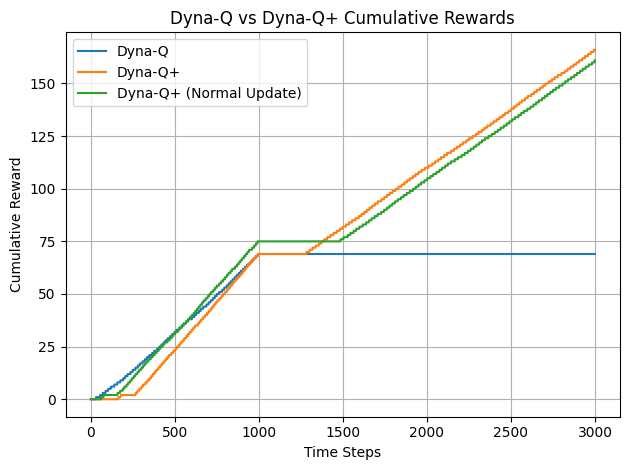

In [155]:
maze = Maze(maze_str)
dyna_q_policy, dyna_q_rewards = dyna_q(
    maze,
    time_steps=3000,
    alpha=0.1,
    gamma=0.95,
    n_planning_steps=50,
    update_time=1000,
    update_function=block_maze,
)

maze = Maze(maze_str)
dyna_q_plus_policy, dyna_q_plus_rewards = dyna_q_plus(
    maze,
    time_steps=3000,
    alpha=0.1,
    gamma=0.95,
    n_planning_steps=50,
    update_time=1000,
    update_function=block_maze,
    exploration_bonus=0.01
)

maze = Maze(maze_str)
dyna_q_plus_2_policy, dyna_q_plus_2_rewards = dyna_q_plus_normal_update(
    maze,
    time_steps=3000,
    alpha=0.1,
    gamma=0.95,
    n_planning_steps=50,
    update_time=1000,
    update_function=block_maze,
    exploration_bonus=0.01
)

plt.plot(dyna_q_rewards, label="Dyna-Q")
plt.plot(dyna_q_plus_rewards, label="Dyna-Q+")
plt.plot(dyna_q_plus_2_rewards, label="Dyna-Q+ (Normal Update)")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Reward")
plt.title("Dyna-Q vs Dyna-Q+ Cumulative Rewards")
plt.legend()
plt.grid()
plt.tight_layout()


plt.show()

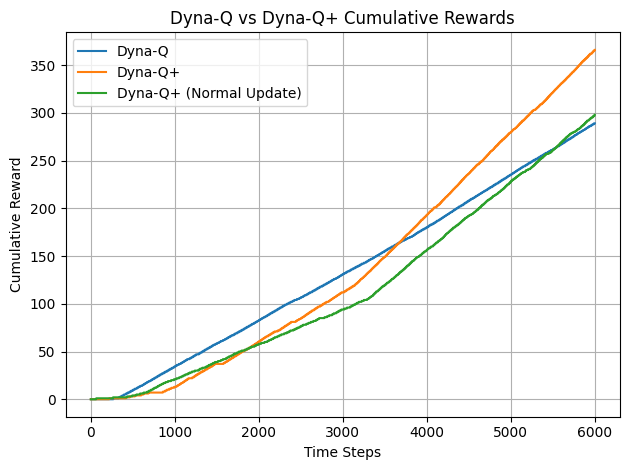

In [159]:
maze = Maze(maze_str_2)
dyna_q_policy, dyna_q_rewards = dyna_q(
    maze,
    time_steps=6000,
    alpha=0.1,
    gamma=0.95,
    n_planning_steps=50,
    update_time=3000,
    update_function=shortcut_maze,
)

maze = Maze(maze_str_2)
dyna_q_plus_policy, dyna_q_plus_rewards = dyna_q_plus(
    maze,
    time_steps=6000,
    alpha=0.1,
    gamma=0.95,
    n_planning_steps=50,
    update_time=3000,
    update_function=shortcut_maze,
    exploration_bonus=0.1
)

maze = Maze(maze_str_2)
dyna_q_plus_2_policy, dyna_q_plus_2_rewards = dyna_q_plus_normal_update(
    maze,
    time_steps=6000,
    alpha=0.1,
    gamma=0.95,
    n_planning_steps=50,
    update_time=3000,
    update_function=shortcut_maze,
    exploration_bonus=0.1
)

plt.plot(dyna_q_rewards, label="Dyna-Q")
plt.plot(dyna_q_plus_rewards, label="Dyna-Q+")
plt.plot(dyna_q_plus_2_rewards, label="Dyna-Q+ (Normal Update)")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Reward")
plt.title("Dyna-Q vs Dyna-Q+ Cumulative Rewards")
plt.legend()
plt.grid()
plt.tight_layout()


plt.show()